# User Segmentation using Clustering Algorithms.

Here we will experiment with user segmentation methods via clustering (Unsupervised Machine Learning). Based on the features provided, we will use tenure and monthly charges as our features as these are numerical, non-correlated features. We will identify the clusters created by k-means and derive business insight from the clusters generated.

K-means clustering works by iteratively performing two steps:

1. **Centroid Assignment**: Each data point $x_i$ is assigned to the nearest centroid $\mu_k$ using Euclidean distance:
    $\text{cluster}(x_i) = \underset{k}{\text{argmin}} ||x_i - \mu_k||^2$

2. **Centroid Update**: Each centroid is updated to be the mean of all points assigned to it:
    $\mu_k = \frac{1}{|C_k|}\sum_{x_i \in C_k} x_i$

where $C_k$ is the set of points in cluster $k$. The algorithm converges when assignments no longer change. The objective is to minimize the within-cluster sum of squares (WCSS):

$J = \sum_{k=1}^{K} \sum_{x_i \in C_k} ||x_i - \mu_k||^2$

## Section 1 : Preparing Data for Modelling

In this section we will slice the features of interest (tenure, MonthlyCharge) and perform feature scaling so we do not observe any feature dominance.

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse
import os
import logging
import sys
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")       

In [2]:
# Import processed dataset
df = pd.read_csv('../data/customer-churn-data-processed.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,0,0,0,0,0,0,1,0,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,...,0,0,0,0,0,0,0,1,1,0
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,0,0,0,0,0,0,0,1,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,1,0,0,0,0,0,0,0,1,0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,0,0,0,0,0,0,1,0,0,0


In [3]:
# Features sliced from the dataset for clustering
features = df[['tenure', 'MonthlyCharges']]

# Standardize the features between 0 and 1
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
# Convert the scaled features back to a DataFrame
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)
# Display the first few rows of the scaled features
print("Scaled Features:")

print(features_scaled.head())

Scaled Features:
Standardized Features:
     tenure  MonthlyCharges
0  0.000000        0.115423
1  0.464789        0.385075
2  0.014085        0.354229
3  0.619718        0.239303
4  0.014085        0.521891


As can be seen from the sampled data, we now have values that range from 0 and 1. The use of Min-Max scaler is rationalised through the different value ranges that tenure and monthly charges. Since K-means calculates euclidean distance between two points if features were on different magnitudes, one feature will dominate over the other in the calculation. 


## Section 2 : Performing Clustering Analysis

Here we will use the implementation of k-means clustering in sci-kit learn to generate meaningful clusters for analysis based on scaled features

Here we will take the following steps :

1. Using the elbow method to find the optimal number of clusters. The elbow method plots the Within-Cluster-Sum-of-Squares (WCSS) against the number of clusters. The optimal number of clusters is typically found at the 'elbow' of the curve.

2. Validating our cluster selection using the silhouette score, which measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1, where:
    - Score close to 1: Well-defined clusters
    - Score close to 0: Overlapping clusters
    - Score close to -1: Incorrect clustering

3. Training the K-means model with the optimal number of clusters identified through these methods to create our final customer segments.

4. Visualizing the resulting clusters to understand the distribution of customers across different segments.

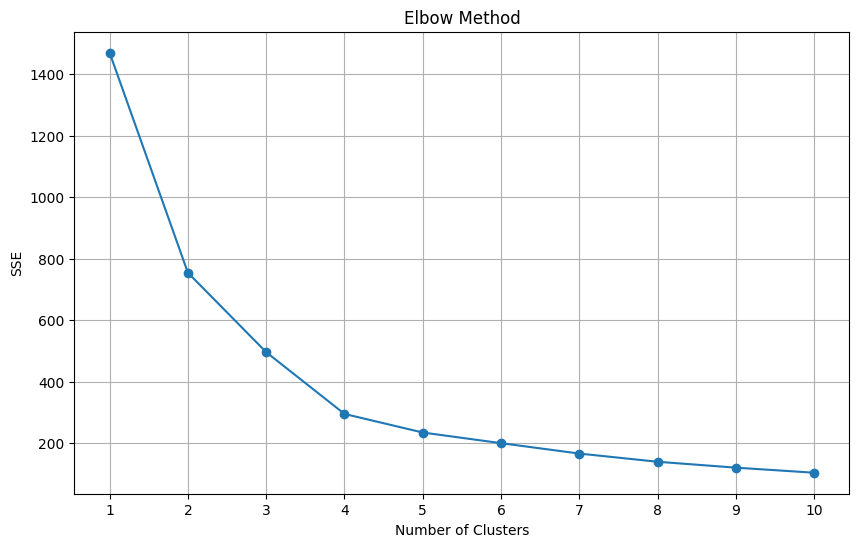

In [4]:
# First we will need to find the optimal number of clusters using the elbow method
# and silhouette score. The elbow method helps to find the number of clusters
# where the within-cluster variance (SSE) starts to decrease at a slower rate.
# The silhouette score measures how similar an object is to its own cluster
# compared to other clusters. A higher silhouette score indicates better-defined clusters.
# Function to calculate silhouette score

def plot_elbow_method(X: pd.DataFrame, max_clusters: int) -> None:
    """
    Plots the elbow method for determining optimal number of clusters.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Training data to cluster
    max_clusters : int
        Maximum number of clusters to test
    """
    sse = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), sse, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid()
    plt.show()

plot_elbow_method(features_scaled, 10)

Using the elbow method we find that the optimal number of clusters lies around n_clusters = 4.

In [5]:
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, 
                    random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, labels)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")

For n_clusters = 2, the silhouette score is 0.43948427197046486
For n_clusters = 3, the silhouette score is 0.4412265096153994
For n_clusters = 4, the silhouette score is 0.4719590557982216
For n_clusters = 5, the silhouette score is 0.4420989617900249
For n_clusters = 6, the silhouette score is 0.42390560005393446
For n_clusters = 7, the silhouette score is 0.4230903222553437
For n_clusters = 8, the silhouette score is 0.4277315207762749
For n_clusters = 9, the silhouette score is 0.43409666113120315
For n_clusters = 10, the silhouette score is 0.43016042653651204


In line with the elbow method, the silhoutte score suggests that the best separation is achieved when n_clusters = 4. In this view, we will use this as our optimal number of clusters when analysing the data.

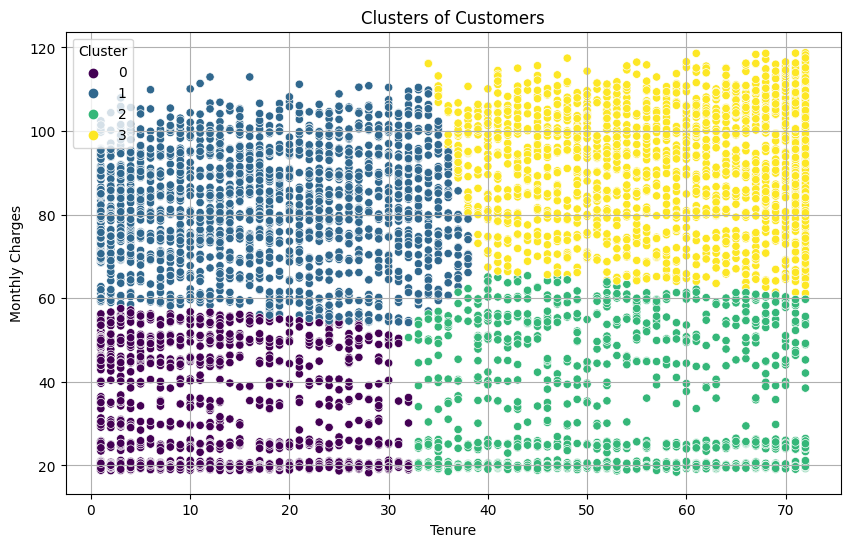

In [6]:
# Fitting KMeans with the optimal number of clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
# Fit the model to the scaled features
kmeans.fit(features_scaled)
# Predict the cluster labels
labels = kmeans.predict(features_scaled)
# Add the cluster labels to the original DataFrame
df['Cluster'] = labels
# Plotting the clusters 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Cluster', palette='viridis')
plt.title('Clusters of Customers')
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.legend(title='Cluster')
plt.grid()
plt.show()

As can be observed from the plots above, there are 4 distinct clusters which we can observe. From this we can identify 4 different personas in our customer base.

| Cluster | Tenure | Monthly Charges | Description |
|---------|---------|-----------------|-------------|
| 0 | Short | Low | short tenure, low monthly charge |
| 1 | Short | High | short tenure, high monthly charge |
| 2 | Long | Low | long tenure, low monthly charge |
| 3 | Long | High | long tenure, high monthly charge |



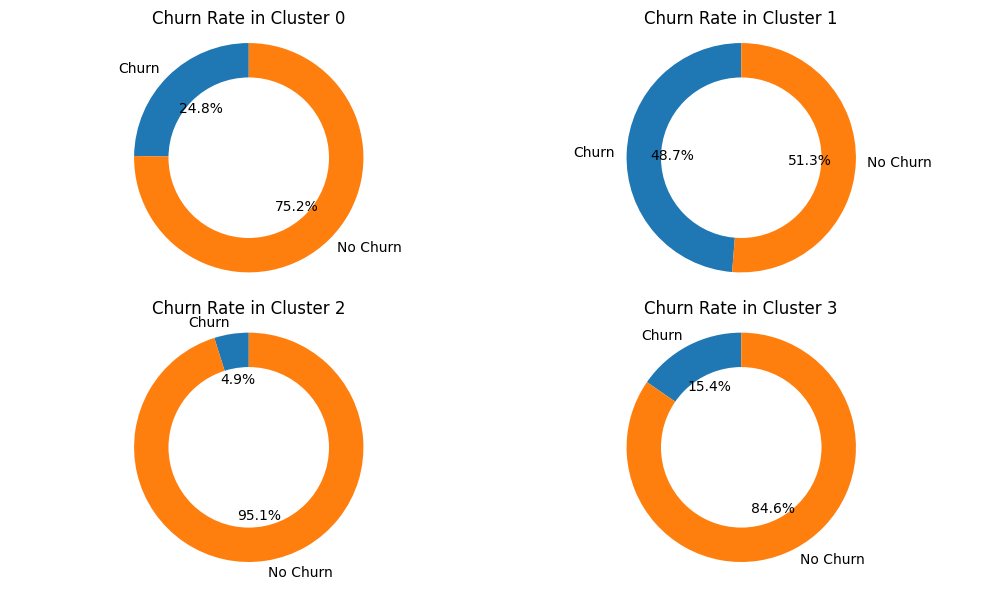

In [7]:
# Lets analyse chun rates in each cluster
# Calculate the churn rate for each cluster
churn_rate = df.groupby('Cluster')['Churn'].mean()  
# Convert to percentage
churn_rate = churn_rate * 100
# Plot the churn rates as donut charts
plt.figure(figsize=(10, 6))
# Create a donut chart for each cluster 
for cluster in churn_rate.index:
    plt.subplot(2, 2, cluster + 1)
    plt.pie([churn_rate[cluster], 100 - churn_rate[cluster]], labels=['Churn', 'No Churn'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Churn Rate in Cluster {cluster}')
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()  

From the donut charts the following can be observed: 

- We see that the highest proportion of churn comes from cluster 1 where they have shorter tenures but higher monthly charges. The inference made here is that customers with shorter tenures who pay more, would probably leave due to pricing

- Interestingly, the second highest proportion of churn is from cluster 0 of those who have short tenures and low monthly charges. This may be an indication of dissatisdaction with the serivce that is being provided.

- Cluster 3 shows the highest proportion of churn out of customers with longer tenures. This again would be due to higher inccurred monthly charges.

- Unremarkably, cluster 2 shows the smallest proportion of churn. We can rationalise this through customers who have stayed long term and are paying less are happy with the service

Based on the analysis above, here are recommended marketing strategies for each cluster:

### Cluster 1 (Short Tenure, High Monthly Charges) - Highest Churn Rate (48.7%)
- Offer temporary price reductions or promotional periods
- Introduce loyalty rewards for staying beyond first year
- Create step-up pricing plans to ease customers into higher charges
- Review service quality to ensure value matches price point

### Cluster 0 (Short Tenure, Low Monthly Charges) - Second Highest Churn (24.8%)
- Implement early engagement programs to build relationship
- Focus on service quality improvements
- Create upgrade paths with clear value propositions
- Develop customer education programs about service features

### Cluster 3 (Long Tenure, High Monthly Charges) - Moderate Churn (15.4%)
- Introduce premium loyalty programs with exclusive benefits
- Offer bundled services with better value
- Provide personalized account management
- Consider grandfathered pricing for longest-standing customers

### Cluster 2 (Long Tenure, Low Monthly Charges) - Lowest Churn (4.9%)
- Maintain current pricing strategy
- Use as reference group for testimonials
- Cross-sell additional services carefully
- Create referral programs to leverage their loyalty

In [8]:
# Generating names for clusters and performing one-hot encoding.

cluster_dict = {
    0: 'Medium Risk Customers',
    1: 'High Risk Customers',
    2: 'Loyal Customers',
    3: 'Premium Customers'
}

df['Cluster'] = df['Cluster'].map(cluster_dict)

df.to_csv('../data/clustered.csv', index=False)
# Perform one-hot encoding on the Cluster column
df = pd.get_dummies(df, columns=['Cluster'], drop_first=True)

df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'InternetService_Fiber optic',
       'InternetService_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Contract_One year', 'Contract_Two year', 'Cluster_Loyal Customers',
       'Cluster_Medium Risk Customers', 'Cluster_Premium Customers'],
      dtype='object')

In [9]:
df.head()
df.to_csv('../data/customer-churn-data-clustered.csv', index=False)